In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

data = torch.load("alpha_1000/loss_log.pt")[::2]

#train_dset = torch.load("alpha_1e-3/train.dset")
#print(len(train_dset))
folder = "../test_case_4/"

gt_initial_beam = torch.load(folder + "ground_truth_dist.pt")


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get predicted covariances
cov = torch.cat([ele[-2].unsqueeze(0) for ele in data]) / 1e6
total_loss = torch.cat([(ele[0] + ele[1]).unsqueeze(0) for ele in data])
total_loss = total_loss - total_loss.min()

# iteration number
t = torch.arange(len(cov))

# get gt cov
gt_cov = torch.cov(gt_initial_beam.T)
gt_rms = torch.diag(gt_cov)

gt_emits = []
for i in range(3):
    g = i*2
    gt_emits.append(torch.det(gt_cov[g:g+2,g:g+2]).sqrt())
    print(gt_emits[-1])

emits = []
for i in range(3):
    g = i*2
    emits.append(torch.det(cov[:, g:g+2,g:g+2]).sqrt())
    print(emits[-1][-1])
    
    
# calculate learning rate
initial_lr = 0.001
n_models = 5
total_iterations = len(cov)
train_period = int(total_iterations / n_models)

lr = 0.5*initial_lr * (torch.cos(3.14*torch.remainder(t-1,train_period) / train_period) + 1.0)
lr = torch.clip(lr, 0.0001)

tensor(2.0000e-06, dtype=torch.float64)
tensor(1.5600e-05, dtype=torch.float64)
tensor(6.7082e-05, dtype=torch.float64)
tensor(2.0973e-06, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.7432e-05, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0316, device='cuda:0', grad_fn=<SelectBackward0>)


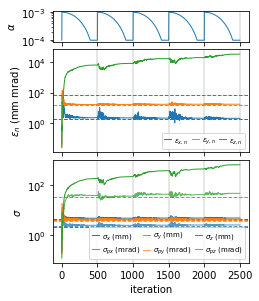

In [14]:
# plot emit_x


fig,(ax_lr, ax, ax2) = plt.subplots(3,1, sharex="all", gridspec_kw={"right": 0.975, "hspace":0.1,"left":0.175,"top":0.975,"bottom":0.1,"height_ratios":[0.3,1.,1.]})
fig.set_size_inches(3.4,4)
labels = ["x", "y", "z"]
lw=1.0
mean_energy = 1
emit_scale = 1e6
ax_lr.plot(t, lr,lw=lw)
ax_lr.set_yscale("log")
ax_lr.set_ylabel(r"$ \alpha $")

for i in range(3):
    ax.semilogy(t, emits[i].cpu().detach() * emit_scale / mean_energy,
                label=f"$\epsilon_{{{labels[i]},n}}$",
                c=f"C{i}",lw=lw)
    ax.axhline(gt_emits[i].cpu().detach() * emit_scale / mean_energy,ls='--',c=f"C{i}",lw=lw)


sigmas = []
labels = ["x", "px", "y", "py", "z", "pz"]
units = ["mm", "mrad"]

from matplotlib import colors

cs = [colors.to_rgba(f"C{i}") for i in [0,1,2]]
cs = [[ele, [*ele[:3] ,0.75]] for ele in cs]
from itertools import chain

cs = list(chain.from_iterable(cs))

sigma_scale = 1e3
for i in range(6):
    sigmas.append(cov[:,i,i].sqrt())
    ax2.semilogy(t, sigmas[-1].cpu().detach() * sigma_scale,
                 label=f"$\sigma_{{{labels[i]}}}$ ({units[i % 2]})",
                c=cs[i],lw=lw)
    ax2.axhline(gt_rms[i].sqrt()*sigma_scale, ls='--', c=cs[i],lw=lw)


# add locations of snapshots
for ele in t[train_period::train_period-1]:
    for a in [ax_lr, ax, ax2]:
        a.axvline(ele, c = "C7",alpha=0.25)
    
ax.set_ylabel("$\epsilon_n$ (mm mrad)")
ax2.set_ylabel("$\sigma$ ")
ax2.set_xlabel("iteration")
fontsize = 7
handletextpad = 0.4
ax.legend(ncol=3, handlelength=1.0, columnspacing=0.5, fontsize=fontsize, handletextpad=handletextpad,loc=4)
ax2.legend(ncol=3, handlelength=1.0, columnspacing=0.5, fontsize=fontsize, handletextpad=handletextpad,loc=4)
#fig.tight_layout()
fig.savefig("convergence.svg")
fig.savefig("convergence.png", dpi=300)


In [ ]:
sigmas = []
fig,ax = plt.subplots()
labels = ["x", "px", "y", "py", "z", "pz"]
for i in range(6):
    sigmas.append(cov[:,i,i].sqrt())
    ax.semilogy(sigmas[-1].cpu().detach(),label=f"$\sigma_{{{labels[i]}}}$",
                c=f"C{i}")
    ax.axhline(gt_rms[i].sqrt(), ls='--', c=f"C{i}")

print(gt_rms[-i].sqrt())
ax.legend()